# Topological post-processing

This notebook demonstrates the application of multi-class, persistent homology (PH)-based topological loss functions within a CNN-based segmentation post-processing framework, reproducing a result described in:

__[N. Byrne, J. R. Clough, I. Valverde, G. Montana and A. P. King, "A persistent homology-based topological loss for CNN-based multi-class segmentation of CMR," in IEEE Transactions on Medical Imaging, 2022, doi: 10.1109/TMI.2022.3203309.](https://doi.org/10.1109/TMI.2022.3203309)__
(also available as an __[arXiv](https://doi.org/10.48550/arXiv.2107.12689)__ pre-print)

This paper provides the theoretical background to our approach, including PH-based losses and the specification of an abstract topological prior based on Betti numbers, including its extension to the multi-class setting by consideration of label combinations. Please see the links above for more information.

The ambition of the example below is to illustrate how we have implemented such loss functions and how, using our wrapper around Shizuo Kaji's amazing __[CubicalRipser](https://github.com/shizuo-kaji/CubicalRipser_3dim)__ repository, our approach can be made efficient.

Please be sure to install the necessary pre-requisites listed in the respository __[readme](https://github.com/nick-byrne/topological-losses/blob/main/README.md#setup)__, and register your device for tensor operations in the cell below.

In [2]:
from importlib import reload
import numpy as np
import torch
import matplotlib.pyplot as plt
from topo import get_differentiable_barcode, multi_class_topological_post_processing
from model.unet import UNet

device = torch.device('cuda:0')

## Setting

This example considers the topology of the heart, or at least its appearance in 2D, short axis cross-section, and relies upon a sample from the publicly available __[ACDC](https://www.creatis.insa-lyon.fr/Challenge/acdc/index.html)__ dataset.

In this view, a mid-ventricular slice demonstrates the right ventricular blood pool cavity (class label 1), the left ventricular myocardium (class label 2) and the left ventricular cavity (class label 3). Prior knowledge expects the left ventricular blood pool to be surrounded by the toroidal myocardium, to which the the right ventricular myocardium is trivially bound (see qualitative results at the end of the notebook).

The topology implied by this qualitative description can be expressed using a vector of Betti numbers $(b_0, b_1)$, specifying the number of connected components ($b_0$) and 1D holes (or loops) contained ($b_1$). The findings of our work suggest that optimising CNN-based segmentation according to a theoretically complete topological description of multi-class anatomy which, in 2D, includes all foreground structures and their pairwise combination. This prior is expressed in the dictionary below, the values of which specify the expected Betti numbers of class label (or class label combination) .

*NB - in 3D the inclusion-exclusion principle requires the specification of Betti numbers for class labels in combinations of up to three. Although this example demonstrates our approach in 2D, the underlying code also provides those addressing 3D problems.*

In [3]:
# Get example image, resample and normalise
image = torch.load('data/image.pt').unsqueeze(0).unsqueeze(0).to(device)
label = torch.load('data/label.pt')

# Set prior: class 1 is RV; 2 is MY; 3 is LV
prior = {
    (1,):   (1, 0),
    (2,):   (1, 1),
    (3,):   (1, 0),
    (1, 2): (1, 1),
    (1, 3): (2, 0),
    (2, 3): (1, 0)
}

## U-Net

Our example provides and relies on a pre-trained 2D U-Net, based on the implementation provided by __[xiaochengcike](https://github.com/xiaochengcike/pytorch-unet-1)__. The pre-trained network parameters were optimised using the ACDC dataset and conventional cross entropy loss function (see our paper for more details).

In [5]:
# Get U-Net model
model = UNet(
    in_channels=1,
    n_classes=4,
    depth=5,
    wf=48,
    padding=True,
    batch_norm=True,
    up_mode='upsample'
)

# Load pre-trained weights and move model to device (GPU recommended)
model_checkpoint = torch.load('model/pre-trained_weights.tar', map_location=device)
model.load_state_dict(model_checkpoint['model_state_dict'])
model = model.to(device)

## Test time adaptation by topological post-processing

In this example, we seek to adapt the weights achieved by conventional pre-training using our multi-class, PH-based topological losses. Having been optimised only for our particular test image, we do expect learned features to generalise to other patients or data.

*NB - Our* `topological_post_processing` *function provides an optional argument to extract the features of the PH in parallel using `multiprocessing`. Note that in this 2D case, the computational cost of establishing multiple processes exceeds that of serial execution.*

In [6]:
# Run topological post-processing
model_TP = multi_class_topological_post_processing(
    inputs=image, model=model, prior=prior,
    lr=1e-5, mse_lambda=1000,
    opt=torch.optim.Adam, num_its=100, construction='0', thresh=0.5, parallel=False
)

/home/nb13/anaconda3/envs/cripser/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


## Results

Run the cell below to examine the results. They demonstrate:

- The propensity of conventionally trained segmentation CNNs (U-Net) to make predictions that lack anatomical coherence (left hand plot).
- The rectification of such errors by test time adaptation by topological post-processing (TP, right hand plot).

Text(0.5, 0, 'U-Net prediction after TP')

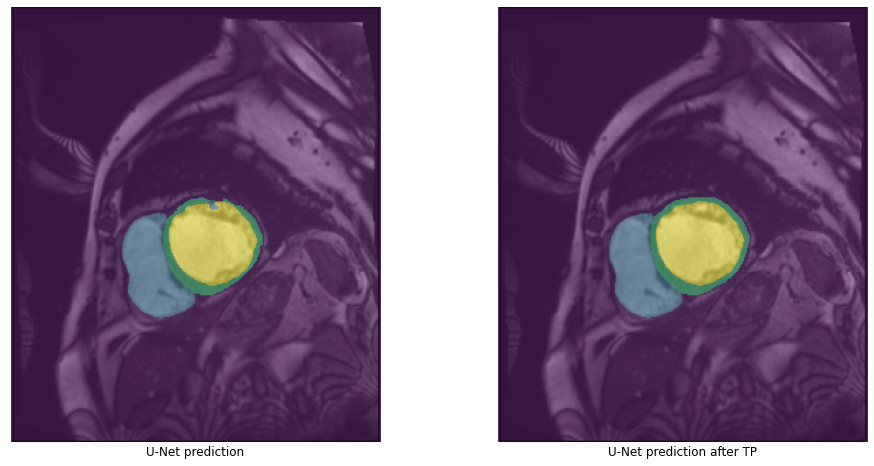

In [7]:
# View results
pred_unet = torch.softmax(model(image), 1).squeeze().argmax(0).cpu().numpy()
pred_topo = torch.softmax(model_TP(image), 1).squeeze().argmax(0).cpu().numpy()

f, ax = plt.subplots(1, 2, figsize=[16, 8])
for a in ax:
    a.imshow(image.cpu().numpy().squeeze(), cmap='gray')
    a.set_xticks([])
    a.set_yticks([])
    plt.setp(a.spines.values(), color=None)

ax[0].imshow(pred_unet, alpha=0.5)
ax[0].set_xlabel('U-Net prediction', size=12)
ax[1].imshow(pred_topo, alpha=0.5)
ax[1].set_xlabel('U-Net prediction after TP', size=12)